<a href="https://colab.research.google.com/github/vanshika2424/brain-tumor-classification/blob/main/brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models, datasets

In [ ]:
base_directory = '/kaggle/input/brain-tumor-mri-dataset'
train, test = 'Training', 'Testing'
target_size = (224, 224)
random_state = 42
batch_size = 16
num_classes = 4
device = "cuda" if torch.cuda.is_available() else "cpu"
label_map = {
    'notumor': 0,
    'glioma': 1,
    'meningioma': 2,
    'pituitary': 3
}

In [ ]:
categories = sorted(os.listdir(base_directory+'/'+train))
print(categories)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
def display_images(dataset_type, num_images=4, image_size=(224, 224)):

    dataset_path = os.path.join(base_directory, dataset_type)

    fig, axes = plt.subplots(len(categories), num_images, figsize=(15, 10))

    for row, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        image_filenames = random.sample(os.listdir(category_path), num_images)  # Select random images

        for col, image_filename in enumerate(image_filenames):
            while image_filename == '.DS_Store':
                image_filename = random.sample(os.listdir(category_path), 1)[0]
            image_path = os.path.join(category_path, image_filename)
            image = Image.open(image_path).resize(image_size)
            axes[row, col].imshow(image, cmap='gray')
            axes[row, col].axis('off')
            axes[row, col].set_title(f"{category}")

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_class_distribution(dataset_type):
    path = os.path.join(base_directory, dataset_type)
    counts = [len(os.listdir(os.path.join(path, cat))) for cat in categories]

    plt.bar(categories, counts, color = ['navy', 'teal', 'darkorange', 'crimson'])
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(f"{dataset_type.capitalize()} Set Distribution")
    plt.show()

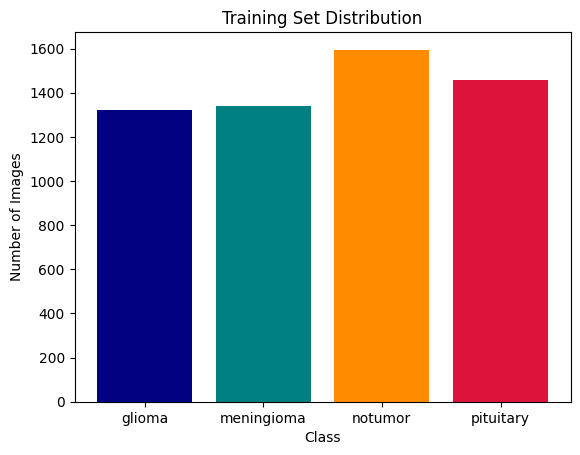

In [ ]:
plot_class_distribution(train)

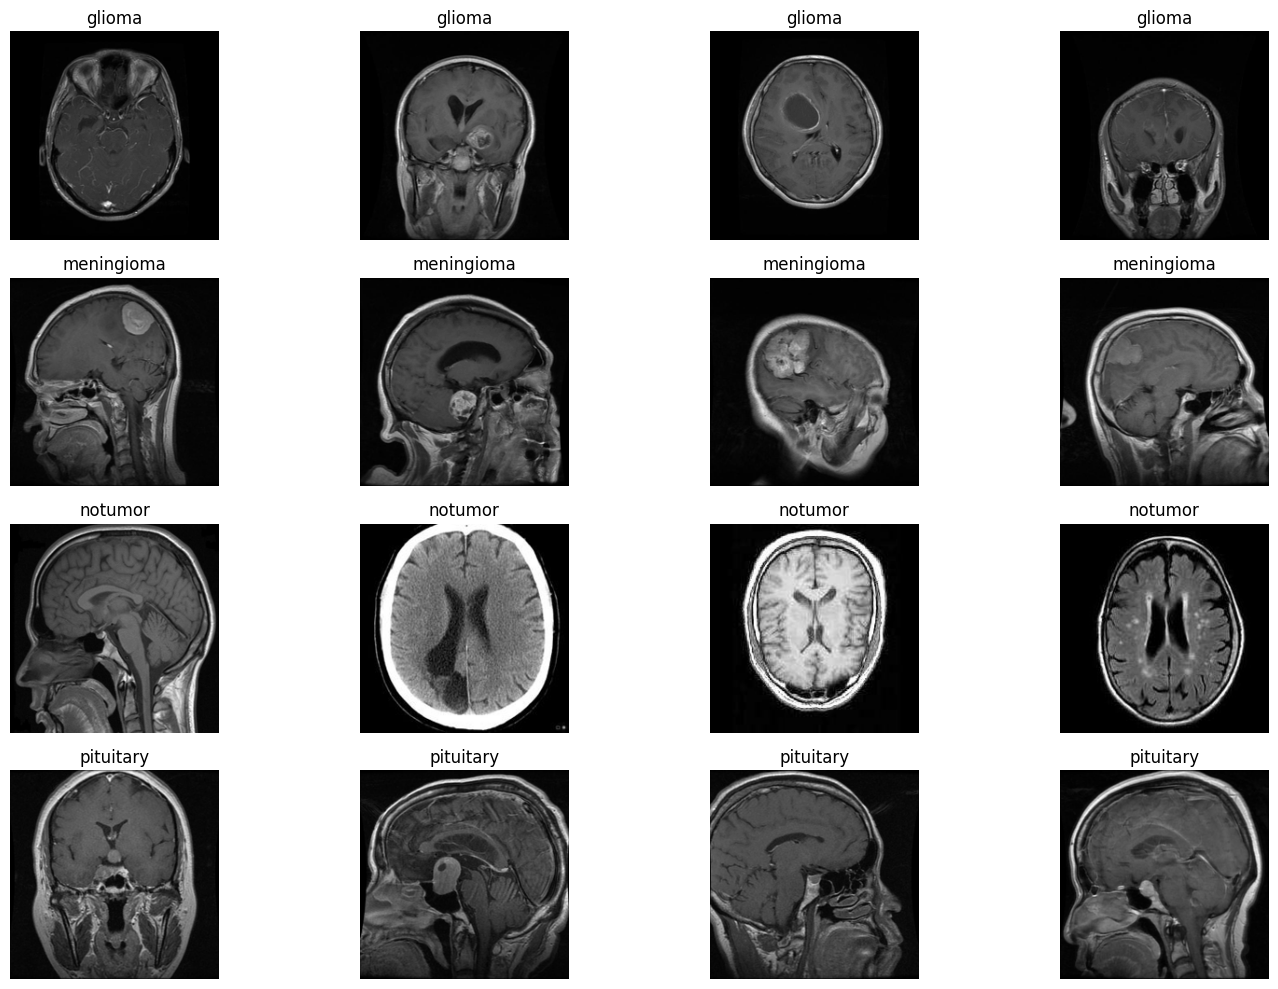

In [ ]:
display_images(train)

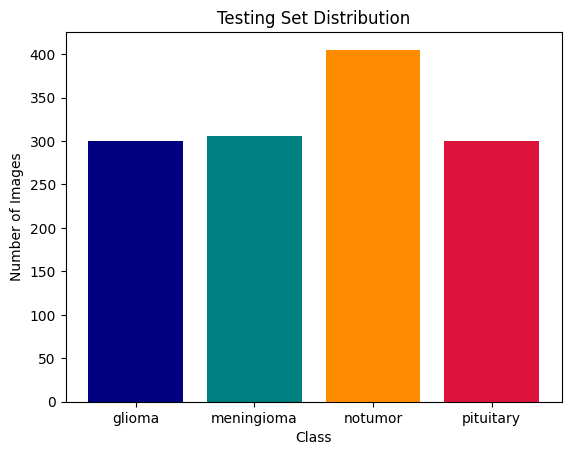

In [ ]:
plot_class_distribution(test)

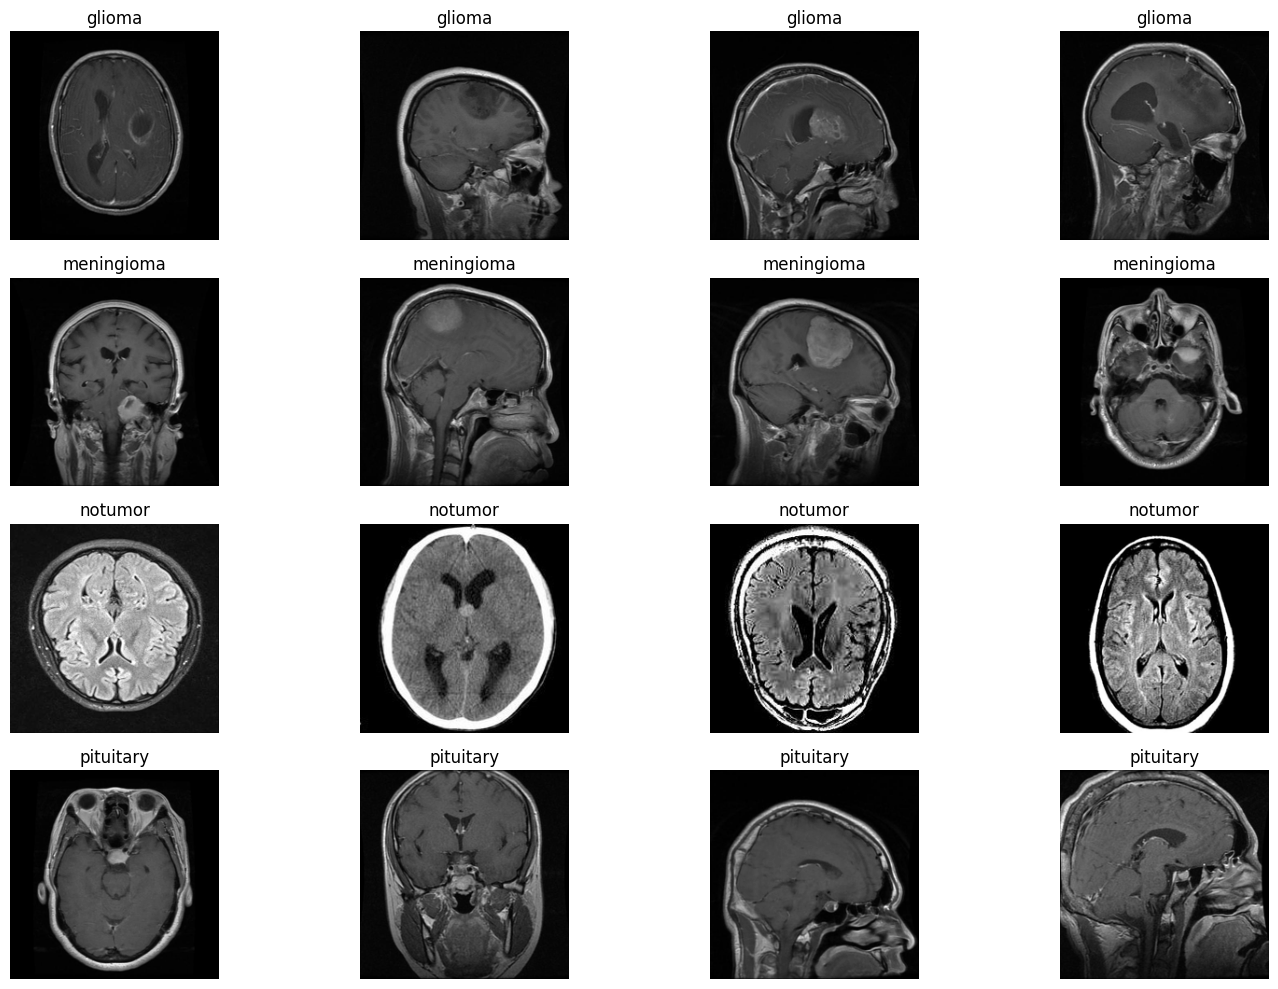

In [ ]:
display_images(test)

In [ ]:
def create_dataset(path):
    my_list = []
    for category in categories:
        category_path = os.path.join(path, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            # Ensure we're only adding image files
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                my_list.append([file_path, category])
    return pd.DataFrame(my_list, columns=['file_path', 'label'])

In [ ]:
train_df = create_dataset(base_directory+'/'+train)
test_df = create_dataset(base_directory+'/'+test)

In [ ]:
train_df['label'] = train_df['label'].map(label_map)
test_df['label'] = test_df['label'].map(label_map)

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = int(self.dataframe.iloc[idx, 1])
        img = Image.open(img_path).convert('L')

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
import cv2
import numpy as np
from PIL import Image

class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        # Convert PIL Image to numpy
        img_np = np.array(img)

        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        img_clahe = clahe.apply(img_np)

        # Convert back to PIL
        return Image.fromarray(img_clahe)


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    CLAHETransform(),   # apply CLAHE instead of ColorJitter
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # for grayscale images
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    CLAHETransform(),   #apply CLAHE for test images too
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # grayscale normalization
])


In [ ]:
test_df_split, val_df_split = train_test_split(test_df, test_size=0.5, random_state=random_state)
# Reset indices for consistency
test_df_split = test_df_split.reset_index(drop=True)
val_df_split = val_df_split.reset_index(drop=True)

In [ ]:
train_dataset = ImageDataset(train_df, transform=train_transform)
val_dataset = ImageDataset(val_df_split, transform=test_transform)
test_dataset = ImageDataset(test_df_split, transform=test_transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torch
import torch.nn as nn

class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Change input channels from 3 → 1 (grayscale images)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.pool(self.relu(self.conv5(x)))

        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x


In [ ]:
model = BrainTumorCNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, name='model', patience=7):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_loss = float("inf")
    tolerance = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).long()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).long()
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
        print("#" * 80)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_brain_tumor_{name}.pth')
            tolerance = 0
        else:
            tolerance += 1
            if tolerance >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    return history


In [ ]:
def test_model(model, test_loader, num_images_to_show=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu())

    test_acc = 100 * correct / total

    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Accuracy: {test_acc:.2f}%\n")

    # Print classification report
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=categories))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=categories, yticklabels=categories)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [ ]:
print("Starting training...")
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

Starting training...
Epoch [1/20]
Train Loss: 0.9588, Train Accuracy: 59.47%
Val Loss: 0.7565, Val Accuracy: 70.43%
################################################################################
Epoch [2/20]
Train Loss: 0.6101, Train Accuracy: 76.14%
Val Loss: 0.6234, Val Accuracy: 76.22%
################################################################################
Epoch [3/20]
Train Loss: 0.4917, Train Accuracy: 81.50%
Val Loss: 0.5379, Val Accuracy: 79.12%
################################################################################
Epoch [4/20]
Train Loss: 0.4159, Train Accuracy: 85.07%
Val Loss: 0.5397, Val Accuracy: 81.10%
################################################################################
Epoch [5/20]
Train Loss: 0.3760, Train Accuracy: 85.80%
Val Loss: 0.3818, Val Accuracy: 85.52%
################################################################################
Epoch [6/20]
Train Loss: 0.3321, Train Accuracy: 88.11%
Val Loss: 0.3749, Val Accuracy: 85.67%
####

In [ ]:
def plot_training_history(history, model_name="model"):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

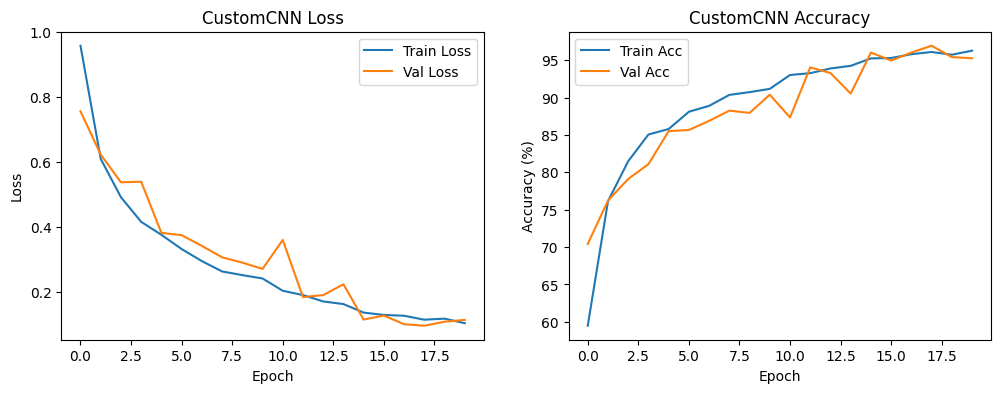

In [ ]:
plot_training_history(history, model_name="CustomCNN")


Loading best model for testing...
Test Accuracy: 96.64%

Classification Report:

              precision    recall  f1-score   support

      glioma       0.98      0.99      0.98       213
  meningioma       0.97      0.94      0.95       149
     notumor       0.93      0.95      0.94       142
   pituitary       0.98      0.98      0.98       151

    accuracy                           0.97       655
   macro avg       0.96      0.96      0.96       655
weighted avg       0.97      0.97      0.97       655



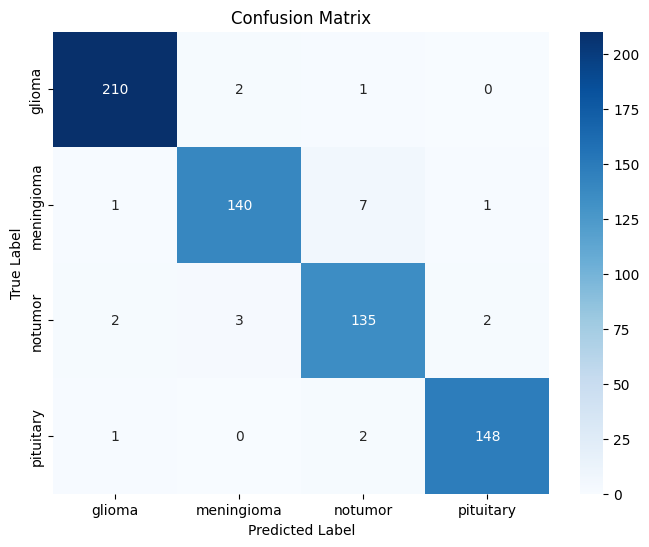

In [ ]:
print("\nLoading best model for testing...")
model.load_state_dict(torch.load('best_brain_tumor_model.pth'))
test_model(model, test_loader)

In [ ]:
def visualize_predictions(model, test_loader, num_images=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct_images, incorrect_images = [], []
    correct_labels, incorrect_labels = [], []
    correct_preds, incorrect_preds = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(predicted)):
                if predicted[i] == labels[i]:
                    correct_images.append(images[i])
                    correct_labels.append(labels[i].cpu().item())
                    correct_preds.append(predicted[i].cpu().item())
                else:
                    incorrect_images.append(images[i])
                    incorrect_labels.append(labels[i].cpu().item())
                    incorrect_preds.append(predicted[i].cpu().item())


    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)

    num_cols = num_images // 2
    plt.figure(figsize=(15, 7))

    for i, img_tensor in enumerate(correct_images[:num_images // 2]):
        img_tensor = img_tensor * std + mean
        img = np.clip(img_tensor.permute(1, 2, 0).cpu().numpy(), 0, 1)
        plt.subplot(2, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f"True: {categories[correct_labels[i]]}\nPred: {categories[correct_preds[i]]}", color='green', fontsize=15)
        plt.axis('off')

    for i, img_tensor in enumerate(incorrect_images[:num_images // 2]):
        if i >= len(incorrect_images):
            plt.axis('off')
            continue
        img_tensor = img_tensor * std + mean
        img = np.clip(img_tensor.permute(1, 2, 0).cpu().numpy(), 0, 1)
        plt.subplot(2, num_cols, num_cols + i + 1)
        plt.imshow(img)
        plt.title(f"True: {categories[incorrect_labels[i]]}\nPred: {categories[incorrect_preds[i]]}", color='red', fontsize=15)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


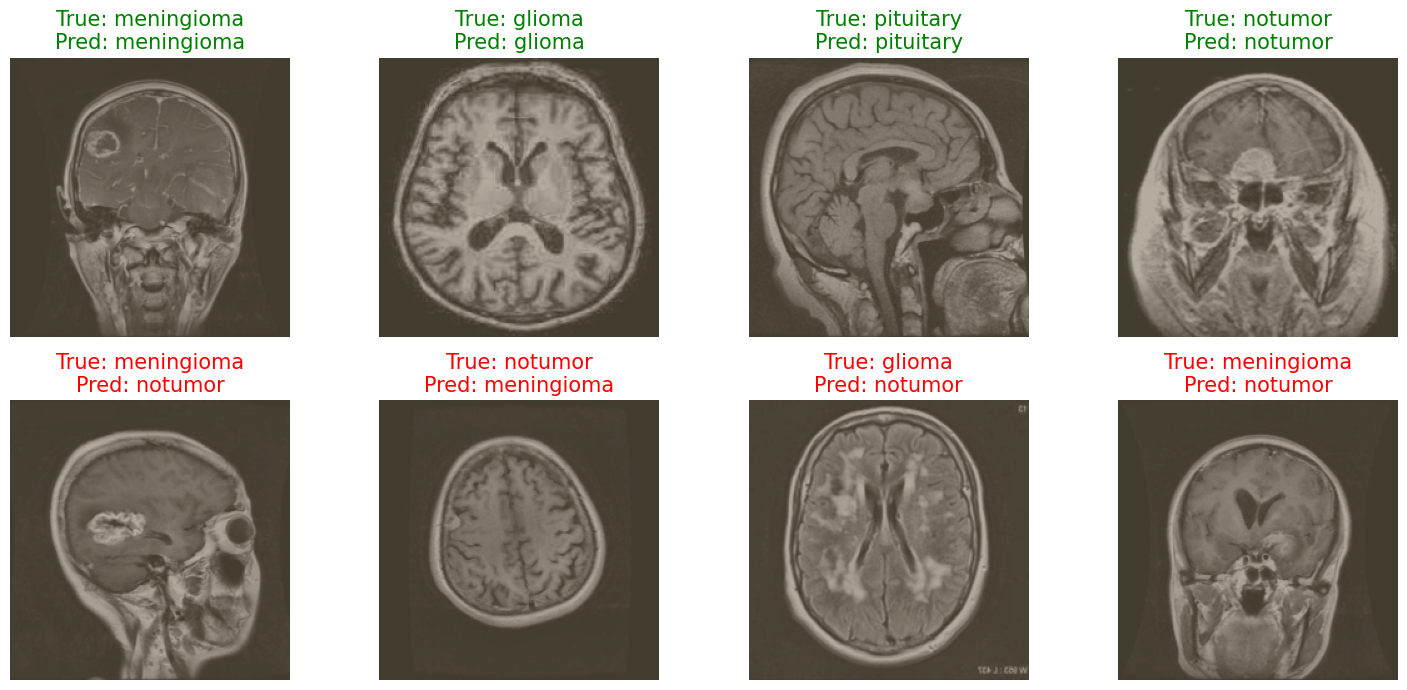

In [ ]:
visualize_predictions(model, test_loader, 8)